# MACHINE LEARNING TECHNIQUES FOR OIL SPILL DETECTION

### Manuel Gabrielli - manuel.gabrielli@studio.unibo.it


---


In this project I experiment two different techniques, Convolutional Neural Networks and Transfer Learning, for oil spill detection. I also consider techniques for data augmentation and artificial noise generation, to provide a wider spectrum of experiments.



# Libraries

In this section I import all the libraries necessary for the development of the project.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from os.path import exists
from sklearn.preprocessing import MultiLabelBinarizer
from time import perf_counter

from tensorflow import keras
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_sample_weight
import tensorflow_hub as hub

# Data Preparation

In this section I prepare the DataFrames used by the models.

First I download the Oil Spill Detection Dataset, developed by Social Media Analytics Laboratory (MKLab), from my project folder in Github.

**Oil Spill Detection Dataset** contains jpg images extracted from satellite Synthetic Aperture Radar (SAR) data depicting oil spills and other relevant instances, and their corresponding ground truth masks. 

Initial SAR data were collected from the European Space Agency (ESA) database, the Copernicus Open Access Hub acquired via the Sentinel-1 European Satellite missions. 

The required geographic coordinates and time of the confirmed oil spills were provided by the European Maritime Safety Agency (EMSA) based on the CleanSeaNet service records, covering a period from 28/09/2015 up to 31/10/2017.

In [ ]:
#check the existence of the file
zip_path = "/tmp/oil-spill-detection.zip";

if not exists(zip_path):
  !wget --no-check-certificate \
      "https://github.com/ManuelGabrielli/gabrielli-Machine-Learning-Techniques-for-Oil-Spill-Detection/archive/refs/heads/master.zip" \
      -O "/tmp/oil-spill-detection.zip"

  zip_ref = zipfile.ZipFile(zip_path, 'r') #Opens the zip file in read mode
  zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
  zip_ref.close()

The developed dataset contains around 1000 images for training and 110 images for testing, depicting instances of 5 classes, namely '*Sea Surface*', '*Oil Spill*', '*Look-alike*', '*Land*' and'*Ship*'.


Data are split into training and test sets.

Each set contains three folders, namely:
*   images: SAR images (.jpg)
*   labels: ground truth segmentation RGB masks (.png)
*  labels_1D: ground truth segmentation labels (.png)


In [ ]:
dataset_path = '/tmp/gabrielli-Machine-Learning-Techniques-for-Oil-Spill-Detection-master/Software and Data/Oil Spill Detection Dataset'
lenTestSet = len(os.listdir(dataset_path+'/test/images'))
lenTrainSet = len(os.listdir(dataset_path+'/train/images'))
print('Number of images in the Test set' , lenTestSet)
print('Number of images in the Train set' , lenTrainSet)

Number of images in the Test set 110
Number of images in the Train set 1002


The possible labels are five and each of them is linked to a number, decided by the creators of the Dataset. In particular, the 'Look-alike' class identifies stains that are similar to oil stains but are not.

In [ ]:
labels = {0:'Sea Surface', 1:'Oil Spill', 2:'Look-alike', 3:'Ship', 4:'Land'}

Each image can be associated with one or more classes based on what elements it represents. So, for example, an image can only represent '*Sea Surface*' or it can contain both '*Sea Surface*' and '*Oil Spill*' and therefore be associated with both classes.

In order to obtain the DataFrame that contains information about the classes to which each image belongs, I created a function, called createDataFrame, that takes as arguments the name of the folder of the Dataset (train or test) and the number of images that it contains, and returns the DataFrame created.

The classes associated with each image are taken by analyzing the respective 1D image. The 1D images are images that contains only values from 0 to 4 associated to each pixel. In particular, if a pixel in the original image displays a part of '*Sea Surface*', in the corresponding 1D image it will have the value 0.

In [ ]:
def createDataFrame(name, length):
  tmp_dict = {}

  for i in range(1, length+1):
    image_name = 'img_'+'%04d'%i

    #this takes the list of classes present in the image 
    img = Image.open(dataset_path+'/'+name+'/labels_1D/'+image_name+'.png').convert('RGBA')
    arr = np.array(img)

    # make a 1-dimensional view of arr
    flat_arr = arr.ravel()

    # convert it to a matrix
    vector = np.matrix(flat_arr)

    x=np.array(vector)
    values = np.unique(x)
    values = values[:-1] #discard the last value which is always 255

    tmp_dict[image_name] = values

  #use MultiLabelBinazer to transform the values in a multilabel format  
  mlb = MultiLabelBinarizer()
  df_values = mlb.fit_transform(tmp_dict.values())

  #create dataframe
  df = pd.DataFrame(df_values, 
                    columns=labels.values())
  
  df['Filenames'] = tmp_dict.keys()
  df['Filenames'] = df['Filenames']+'.jpg'
  
  return df

Now I extract the DataFrames from the train and test images. However, If the .csv files of the DataFrames already exist, I just read them and don't recreate them.

In [ ]:
#check if the .csv files of the dataframes already exist, if they don't exist I create them otherwise I read them directly
path_train_df = dataset_path+"/train_dataframe.csv"
path_test_df = dataset_path+"/test_dataframe.csv"

if exists(path_train_df):
  df_train = pd.read_csv(path_train_df, delimiter=',')
else:
  df_train = createDataFrame('train', lenTrainSet)
  #save dataframe
  df_train.to_csv(path_train_df,index=False)

if exists(path_test_df):
  df_test = pd.read_csv(path_test_df, delimiter=',')
else:
  df_test = createDataFrame('test', lenTestSet)
  df_test.to_csv(path_test_df,index=False)

The resulting DataFrames, one for the test images and one for the train images, have the same structure. For each image, the name is contained in the '*Filenames*' column, the value of the remaining columns, one for each possible class, is 0 if the image does not show that element, otherwise it is 1. 

In [ ]:
df_train.head(5)

,Sea Surface,Oil Spill,Look-alike,Ship,Land,Filenames
0,1,1,0,0,0,img_0001.jpg
1,1,1,1,0,0,img_0002.jpg
2,1,1,0,0,0,img_0003.jpg
3,1,1,1,0,0,img_0004.jpg
4,1,1,0,0,0,img_0005.jpg


In [ ]:
df_test.head(5)

,Sea Surface,Oil Spill,Look-alike,Ship,Land,Filenames
0,1,1,0,1,0,img_0001.jpg
1,1,0,1,0,1,img_0002.jpg
2,1,1,1,0,1,img_0003.jpg
3,1,0,1,0,0,img_0004.jpg
4,1,1,0,1,0,img_0005.jpg


I create an Histogram for each class of the training images, in order to understand their distribution.

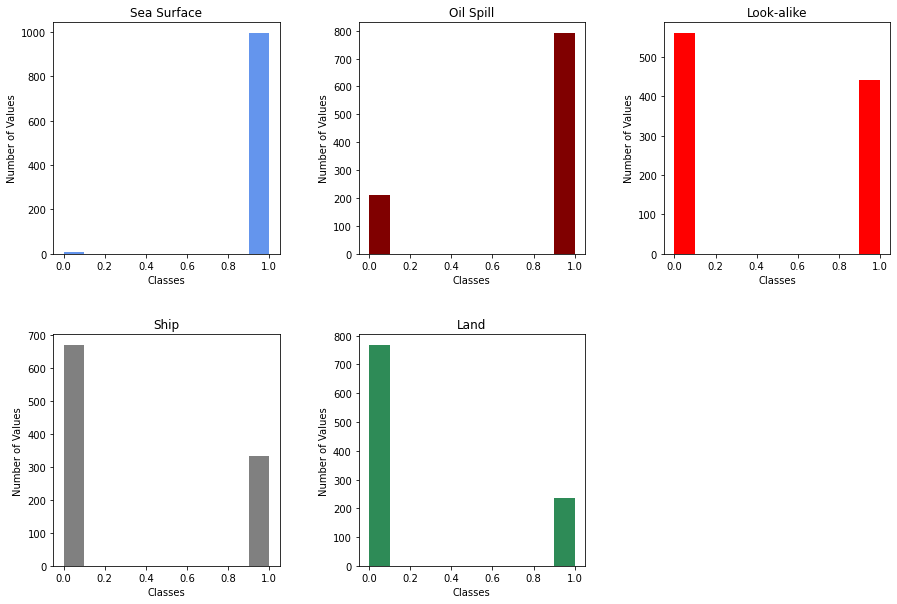

In [ ]:
cols = list(labels.values())#list of all the possible values

f, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

colors=["cornflowerblue","maroon","red","gray","seagreen"]

#create a histogram for each column
for i in range(len(cols)):
    axes[i].hist(df_train[cols[i]], color =colors[i]);
    axes[i].set_title(cols[i])
    axes[i].set_xlabel("Classes")
    axes[i].set_ylabel("Number of Values")


axes[-1].axis('off') #don't display th axes of the last plot
plt.subplots_adjust(wspace=0.35, hspace=0.35) #adjust spaces between graphs
plt.show()

Since the bins are not the same height, it is evident that the class values in the images are highly unbalanced, especially for the '*Sea Surface*' class where the images that does not show the sea are few samples.

# Data Augmentation

In this section I create generators of new images obtained by modifying those already present, in order to obtain a larger set of images to be submitted to the models during the training phase.

Image augmentation is a technique of applying different transformations to original images which results in multiple transformed copies of the same image. Each copy, however, is different from the other in certain aspects depending on the augmentation techniques. In this project I decided to apply a set of transformations, including rescaling, rotation, zoom, shifts, horizontal flip and changes of the brightness.

These image augmentation techniques not only expand the size of the dataset but also incorporate a level of variation which allows the model to generalize better on unseen data. Also, the model becomes more robust when it is trained on new, slightly altered images.

In [ ]:
rescale=1./255.;
rotation_range = 10;
width_shift_range=0.2; 
height_shift_range=0.2; 
zoom_range=0.2; 
horizontal_flip=True; 
brightness_range=[0.2,1.2];

In order to achive Data Augmentation I use ***ImageDataGenerator***, provided by Keras.

It provides a host of different augmentation techniques and real-time data augmentation. In fact, it generates augmented images on the fly while the model is still in the training stage, ensuring that the model receives new variations of the images at each epoch. ImageDataGenerator also requires lower memory usage, due to the fact that it loads the images in batches, which saves a lot of memory.

I produce two Generators, one is used for the training images and applies all the transformations, the other is used for the test images and applies only the rescailing operation, which is compulsory.

In [ ]:
# ImageDataGenerator
datagen = ImageDataGenerator(
        rescale=rescale,
        rotation_range=rotation_range, # rotation
        width_shift_range=width_shift_range, # horizontal shift
        height_shift_range=height_shift_range, # vertical shift
        zoom_range=zoom_range, # zoom
        horizontal_flip=horizontal_flip, # horizontal flip
        brightness_range=brightness_range) # brightness

#generator for test images
test_datagen = ImageDataGenerator(rescale=rescale)

Since the instances of the classes are very unbalanced I compute the weights of each sample to take into account during training.

The method '*compute_sample_weight*' estimates sample weights by class.

In [ ]:
weights = compute_sample_weight(class_weight='balanced', y = df_train.drop(columns = 'Filenames'))

As an example, this vector gives a higher weight to the items that do not contain '*Sea Surface*', due to the fact that the number of those items are much less than those that contain it.

In [ ]:
print(f"Random examples of items' weights without label 'Sea Surface': {weights[78]:0.3f} and {weights[302]:0.3f}\n")
print(f"Random examples of items' weights with label 'Sea Surface': {weights[1]:0.3f} and {weights[34]:0.3f}")

Random examples of items' weights without label 'Sea Surface': 241.633 and 241.633

Random examples of items' weights with label 'Sea Surface': 0.178 and 0.279


After calculating the weight of each element, I add a column, called '*Weights*', to the training dataframe. This will be sent to the generator of images.

In [ ]:
df_train_weighted = df_train.copy()
df_train_weighted['Weights'] = weights

Finally, I create three Generators, the first is used to train the model, the second to evaluate the model during the training and the third to compare the predictions with the real values.

Each Generator takes as parameter:
* the DataFrame; 
* the path to the folder containing the images;
* the name of the column of the DataFrame that contains the weights of the   samples;
* the name of the column that contains the names of the images;
* the number of batches for the training of the model;
* the seed;
* an indication of whether the order of the images should be shuffled;
* the class mode;
* the size of the target image.

In [ ]:
#parameters
random_seed = 42;
batch_size_train = 64;
batch_size_test = 1;
image_size = (400,400);

In [ ]:
train_generator = datagen.flow_from_dataframe(
  dataframe=df_train_weighted,
  directory=dataset_path+'/train/images/',
  weight_col="Weights",
  x_col="Filenames",
  y_col=cols,
  batch_size=batch_size_train,
  seed=random_seed,
  shuffle=True,
  class_mode="raw",
  target_size=image_size)

valid_generator = test_datagen.flow_from_dataframe(
  dataframe=df_test,
  directory=dataset_path+'/test/images/',
  x_col="Filenames",
  y_col=cols,
  batch_size=batch_size_train,
  seed=random_seed,
  shuffle=True,
  class_mode="raw",
  target_size=image_size)

test_generator = test_datagen.flow_from_dataframe(
  dataframe=df_test,
  directory=dataset_path+'/test/images/',
  x_col="Filenames",
  batch_size=batch_size_test,
  seed=random_seed,
  shuffle=False,
  class_mode=None,
  target_size=image_size)

# CNN Model creation

In this section I create and preapare the **2D Convolutional Neural Network**.

CNNs are a specialised kind of Neural Network for processing data
that have a known grid-like topology:
* Time series data (1D grid);
* Image data (2D grid).

CNNs employ a mathematical operation called convolution, extremely fast in computation.
They are Neural Networks that use convolution in place of general matrix multiplication in at least one of their layers.

I use the Sequential model of Keras, which allows to create models layer-by-layer. 

So, I create a function, called *createModel*, that creates a model composed by 4 Convolutional layers, 2 deeply connected neural network layers and 1 final output layer.

To increase the stability of the neural network I use the *BatchNormalization* method, which normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation.

I use *Dropout* method to avoid the over-fitting. It is a regularization method. The value passed in *Dropout* specifies the probability at which outputs of the layer are dropped out.

Lastly, I use *Dense*, which is the regular deeply connected neural network layer. Even if here I have 5 outputs, I still use the activation function 'sigmoid', and not the softmax function, because the target variable *y* has 1 and 0 values.

The output layer has 5 neurons, equal to the number of classes.

In [ ]:
def createModel():
  #A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
  model = Sequential()

  #FIRST LAYER
  #The input_shape specifies the shape of the input. It is a necessary parameter for the first layer in any neural network.   
  #I only use the input_shape in the first layer.
  #ReLU is a piece wise linear function that will output the input directly if it is positive, otherwise, it will give the output as zero
  model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(400, 400, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  #SECOND LAYER
  model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  #THIRD LAYER
  model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  #FOURTH LAYER
  model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  #Flatten() is used to convert the data into a one-dimensional array for the further process
  model.add(Flatten())
  
  model.add(Dense(64, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(128, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  
  model.add(Dense(5, activation='sigmoid'))

  return model

Then I call the function to create the model.

In [ ]:
model = createModel()

Now I compile the model, using *binary_crossentropy* as the loss and *ADAM* as the optimizer.

I also create the list of metrics, provided by Keras, on which the model should train and improve. 

Since the data are very unbalanced, I decided to consider also precision, recall, f1-score and support measures as metrics. In fact, It is not unusual to observe a high evaluation accuracy when testing a classification model trained on very imbalanced data. In such cases, the accuracy is only reflecting the underlying class distribution.

AUC metric refers to the area under the curve of a receiver operating characteristic curve (ROC-AUC). This metric equals the probability that a classifier will rank a random positive sample higher than a random negative sample.

AUPRC metric refers to the area under the curve of the precision recall curve. This metric calculates the precision recall pairs for different probability thresholds.

In [ ]:
TRAIN_METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=TRAIN_METRICS)

# Training the model

In this section I train the model, created in the previous section, passing to it the train images generator and the test images generator as validation data, which are data on which to evaluate the loss and any metrics of the model at the end of each epoch. The model will not be trained on the valuation data.

In [ ]:
number_of_ephocs = 40;

In [ ]:
# Start the stopwatch / counter
t1_start = perf_counter()

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

model.fit(train_generator, epochs = number_of_ephocs, validation_data=valid_generator, steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID)

# Stop the stopwatch / counter
t1_stop = perf_counter()

In [ ]:
print("Elapsed time in seconds:",t1_stop-t1_start)

Elapsed time in seconds: 2724.906364407


# Plots

In this section I plot the graph of Loss and Accuracy of the trained model.

To do this, I create two functions, one to plot the Loss and one to plot the Accuracy of the model. These functions take as argument the model's history which contains lists of subsequent losses and accuracies values for both training and validation data.

In [ ]:
def plotLoss(history):
  plt.figure(figsize=(10,7))
  plt.plot(history['loss'],color='b', label='Training Loss');
  plt.plot(history['val_loss'],color='r', label='Validation Loss');
  plt.legend()
  plt.ylim(bottom=0)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("Model's Loss", fontsize = 17)
  plt.show();

def plotAccuracy(history):
  plt.figure(figsize=(10,7))
  plt.plot(history['accuracy'],color='b', label='Training Accuracy')
  plt.plot(history['val_accuracy'],color='r', label='Validation Accuracy');
  plt.legend()
  plt.ylim([0,1])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title("Model's Accuracy", fontsize = 17)
  plt.show();

In [ ]:
#get the hostory
hist_m = model.history.history

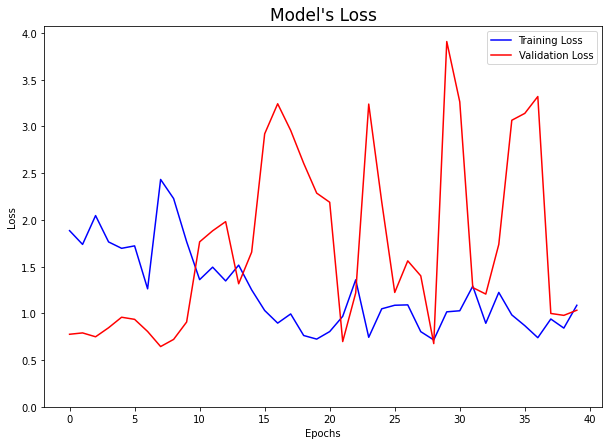

In [ ]:
#Plotting the Loss
plotLoss(hist_m)

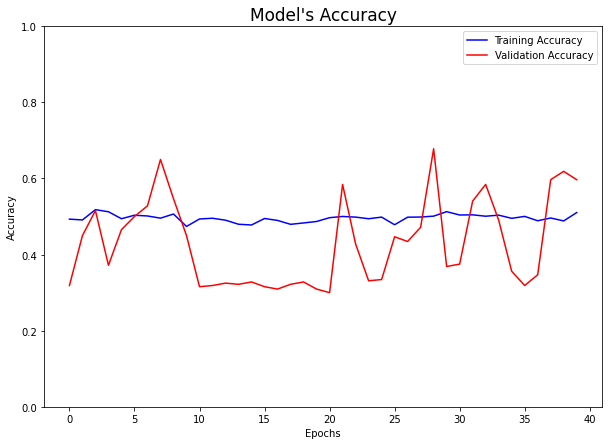

In [ ]:
#Plotting the Accuracy
plotAccuracy(hist_m)

From the graphs it is clear that the values for Loss and Accuracy are not satisfactory at all, but this is due to the unbalanced distribution of classes. In fact, as already announced, when we test a classification model trained on very imbalanced data, those values might not reflect the real potential of the model.

This is the reason why in the following section I test the model on different parameters.

# Model Evaluation

In this section I evaluate the results of the trained model on the test set.

The items can be correctly and incorrectly classified into:
* True positive (TP): Correctly predicting the positive class;
* True Negative (TN): Correctly predicting the negative class;
* False Positive (FP): Incorrectly predicting the positive class;
* False Negative (FN): Incorrectly predicting the negative class;

So, for example, if an image contains '*Sea Surface*' and the model correctly predicts it, it is True Positive, while if the model predicts that the image does not contain '*Sea Surface*', it is False Negative. So in this case positive class is 1, meaning that the image belongs to that class, while negative class is 0, meaning that it does not belong to that class.

Accuracy does not provide the full picture of the model's predictive ability. This is why I consider other metrics, which are more accurate in this case:
* **Precision**, calculated as $\frac{TP}{TP + FP}$, which is a measure of how many of the positive predictions made are correct;

* **Recall**, calculated as $\frac{TP}{TP + FN}$, which is a measure of how many of the positive cases the classifier correctly predicted, over all the positive cases in the data; 

* **F1 score**, calsuated as $\frac{2 * Precison * Recall}{Precision + Recall}$. The idea is to provide a single metric that weights the two ratios (precision and recall) in a balanced way, requiring both to have a higher value for the F1-score value to rise. It is much more sensitive to one of the two inputs having a low value.


I create a function called *getResults*, that returns a dataframe containing the predictions on the images and returns also the classification reports of the predictions.
It takes as parameters a generator of images, a model, the step_size and a boolean value used to indicate wheter the classification report must be a dictionary.  

In [ ]:
def getResults(generator, model, step_size, output_dict):
  generator.reset()

  #Get predictions of the model on the test set.
  pred = model.predict(generator, steps=step_size, verbose=1)

  #get dataframe of the results
  pred_bool = (pred >0.5)
  predictions = pred_bool.astype(int)

  #create dataframe
  results = pd.DataFrame(predictions, columns=cols)
  results["Filenames"] = generator.filenames
  ordered_cols = ["Filenames"]+cols
  results = results[ordered_cols]#To get the same column order

  #create the classification report to obtain all the measurements to evaluate a multilabel model
  rep = classification_report(
    df_test.drop(columns='Filenames'), 
    results.drop(columns='Filenames'),
    output_dict=output_dict,
    target_names=cols
  )

  return results, rep

Another very powerful tool in evaluating data belonging to multiple classes is the **Confusion Matrix**.

A Confusion Matrix is a matrix that shows the number of True Positive, True Negatives, False Positives and False Negatives of the classified elements, referring to a specific class.

In order to obtain the Confusion Matrices of the five classes, I create a function that takes the dataframe containing the predictions and prints a graph containing the Confusion Matrices.

In [ ]:
def printConfusionMatrices(results):
  f, axes = plt.subplots(2, 3, figsize=(25, 15))
  axes = axes.ravel()

  #create a matrix for each column
  for i in range(len(cols)):
      disp = ConfusionMatrixDisplay(confusion_matrix(df_test.drop(columns='Filenames').iloc[:, i],
                                                    results.drop(columns='Filenames').iloc[:, i]),
                                    display_labels=[0, 1])
      disp.plot(ax=axes[i], values_format='.4g')
      disp.ax_.set_title(cols[i])
      disp.im_.colorbar.remove()

  axes[-1].axis('off') #don't display th axes of the last plot
  plt.subplots_adjust(hspace=0.2)
  f.colorbar(disp.im_, ax=axes)
  plt.show()

Now I get the predictions of the model on the test set.

In [ ]:
res, rep = getResults(test_generator, model, STEP_SIZE_TEST, False)

The variable *res* contains the dataframe with the results, while the variable *rep* contains the classification report,

In the classification report the Support is the number of occurrences of each class in the test images.

In [ ]:
print(rep)

              precision    recall  f1-score   support

 Sea Surface       1.00      0.75      0.85       110
   Oil Spill       0.83      0.74      0.78        88
  Look-alike       0.52      0.75      0.61        55
        Ship       0.32      0.68      0.44        34
        Land       0.26      0.35      0.30        26

   micro avg       0.64      0.70      0.67       313
   macro avg       0.59      0.65      0.60       313
weighted avg       0.73      0.70      0.70       313
 samples avg       0.56      0.70      0.60       313



The Precision values are high for '*Sea Surface*' and '*Oil Spill*' classes while relatively low for the other classes, in particular '*Land*'. The Recall values are generally quite high, except for '*Land*' class. This produces quite satisfactory F1-scores for '*Sea Surface*' and '*Oil Spill*' classes, while unsatisfactory values for the others. Therefore, the model is not particularly good at predicting all the classes to which each image belongs.

However, being the focus of the project on the '*Oil Spill*' class, as the goal is to predict oil spills, the particularly low values for the other classes are not a big problem. Clearly the model must be improved.

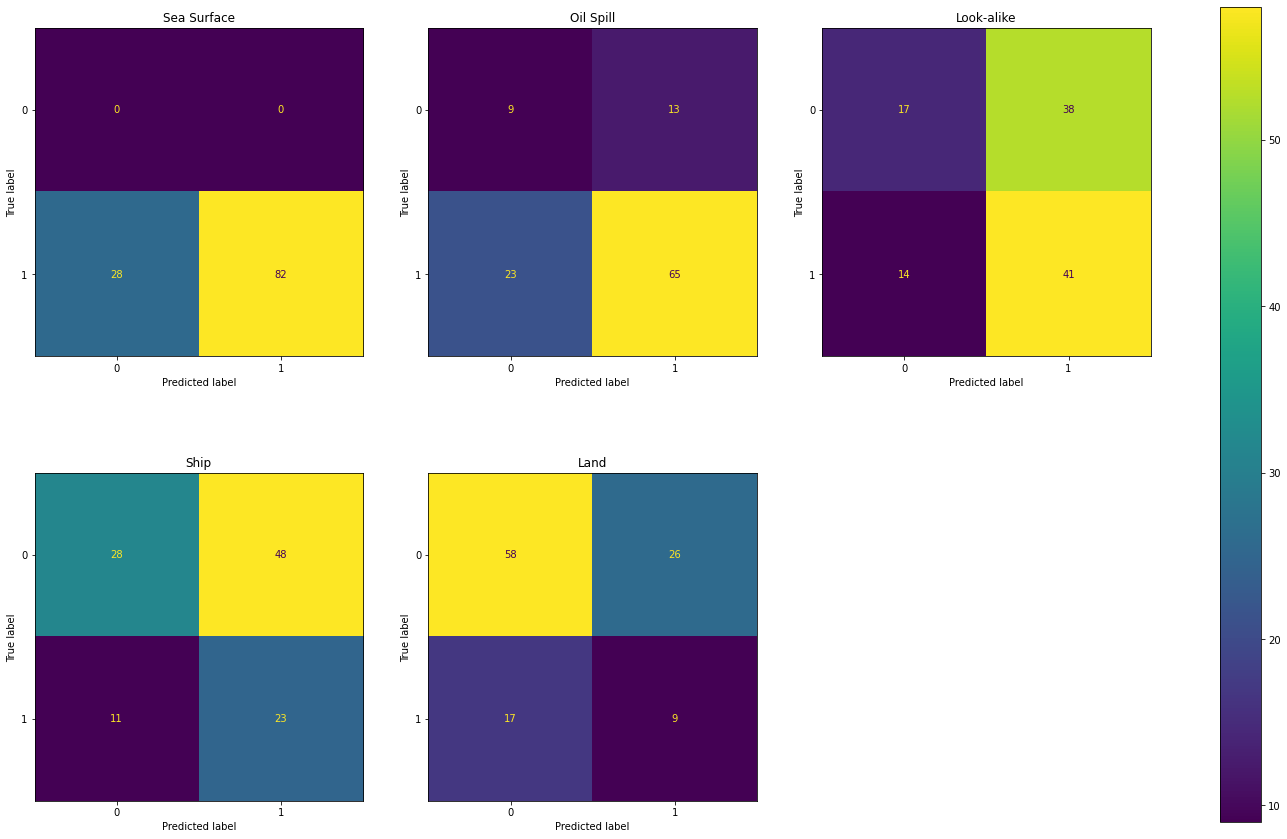

In [ ]:
printConfusionMatrices(res)

The matrices show the number of wrong and correct predictions of the model. It is possible to see that the predictions on the test set are not very accurate, as the values of wrong predictions are very high. In fact, the sums of correctly predicted values and the sums of incorrectly predicted values are, for the last three classes, almost equivalent, or the latter are slightly higher, so the improvement index is high.

# Noise introduction

In this section I introduce noise in the test set to test how much the trained model is robust.

I create a class called *AddNoise* that takes as parameters, during its creation, the image to elaborate and the level of variability of the noise to apply to the image. Then, when it is called, it applies a gaussian noise influenced by the variability. 

In [ ]:
class AddNoise():
    def __init__(self, variability=50):
        self.var = variability
    def __call__(self, img):
        deviation = self.var**0.5
        noise = np.random.normal(0, deviation, img.shape) #0 is the mean
        img += noise
        np.clip(img, 0., 255.)
        return img

An instance of the class *AddNoise* is passed to the function *ImageDataGenerator* to create a generator that applies noise to the image that it creates. 

In [ ]:
def createNoiseGenerator(variability, image_size):
  # ImageDataGenerator to introduce new images affected by noise
  datagenNoise = ImageDataGenerator(rescale=rescale, preprocessing_function=AddNoise(variability))#noise

  return datagenNoise.flow_from_dataframe(
    dataframe=df_test,
    directory=dataset_path+'/test/images/',
    x_col="Filenames",
    batch_size=batch_size_test,
    seed=random_seed,
    shuffle=False,
    class_mode=None,
    target_size=image_size)

I create a function that prints five Line Charts, one for each class, in order to show the changes of the Precision, Recall and F1-score of the model on images subjected to a gradually increasing variability of noise. 

This function, called *printNoiseResults*, takes as parameters a dictionary containing all the values of the evaluation metrics, the list of the classes, the list of the metrics and the range of the noise variability on which the model was tested.

In [ ]:
def printNoiseResults(res_dict, classes, metrics, range_variability):
  f, axes = plt.subplots(2, 3, figsize=(25, 15))
  axes = axes.ravel()

  for c, i in zip(classes, range(len(classes))):
    y_dict = {}

    for m in metrics:
      t=[]
      for j in range(len(res_dict)):
        t.append(res_dict[j][c][m])

      axes[i].plot(range_variability,t, label=m);
      
    axes[i].set_ylim([0,1.1])  
    axes[i].legend()
    axes[i].set_xlabel('Noise variability')
    axes[i].set_title(c, fontsize = 17)

  axes[-1].axis('off') #don't display th axes of the last plot
  plt.subplots_adjust( hspace=0.35) #adjust spaces between graphs
  plt.show();

The range of noise variability that I test goes from 40 to 130, increasing by 10 each time.

In [ ]:
range_variability = range(40, 130, 10);

For every value of noise variability in the range I create a new generator, compute the stepsize and call the function *getResults* to obtain the predictions of the model.

In [ ]:
res_dict = []
for i in range_variability:
  test_generator_noise = createNoiseGenerator(i, image_size);
  step = test_generator_noise.n//test_generator_noise.batch_size
  res_noise, rep_noise = getResults(test_generator_noise, model, step, True);
  res_dict.append(rep_noise);

In [ ]:
metrics_eval = ['f1-score', 'precision', 'recall']

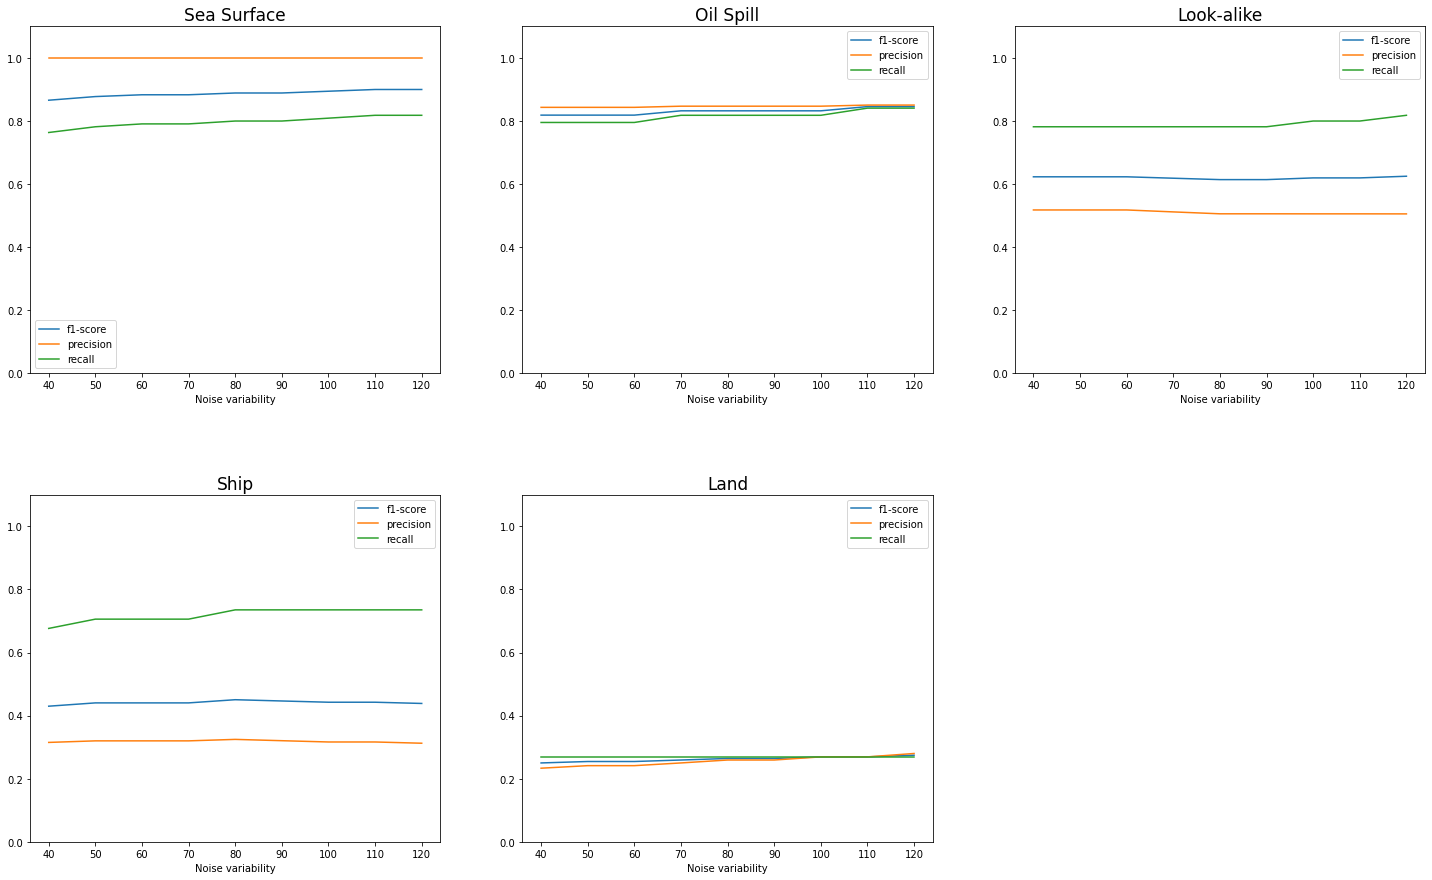

In [ ]:
printNoiseResults(res_dict, cols, metrics_eval, range_variability);

The Precison and Recall values generally remain stable for all five classes. This causes also the stability for the F1-score. 

Therefore, we can see that the model is robust to noise since the values of the evaluation metrics do not decrease much.

Then I print the Confusion Matrices of the results with noise variability equal to 130 to compare them with the matrices obtained on images without noise.

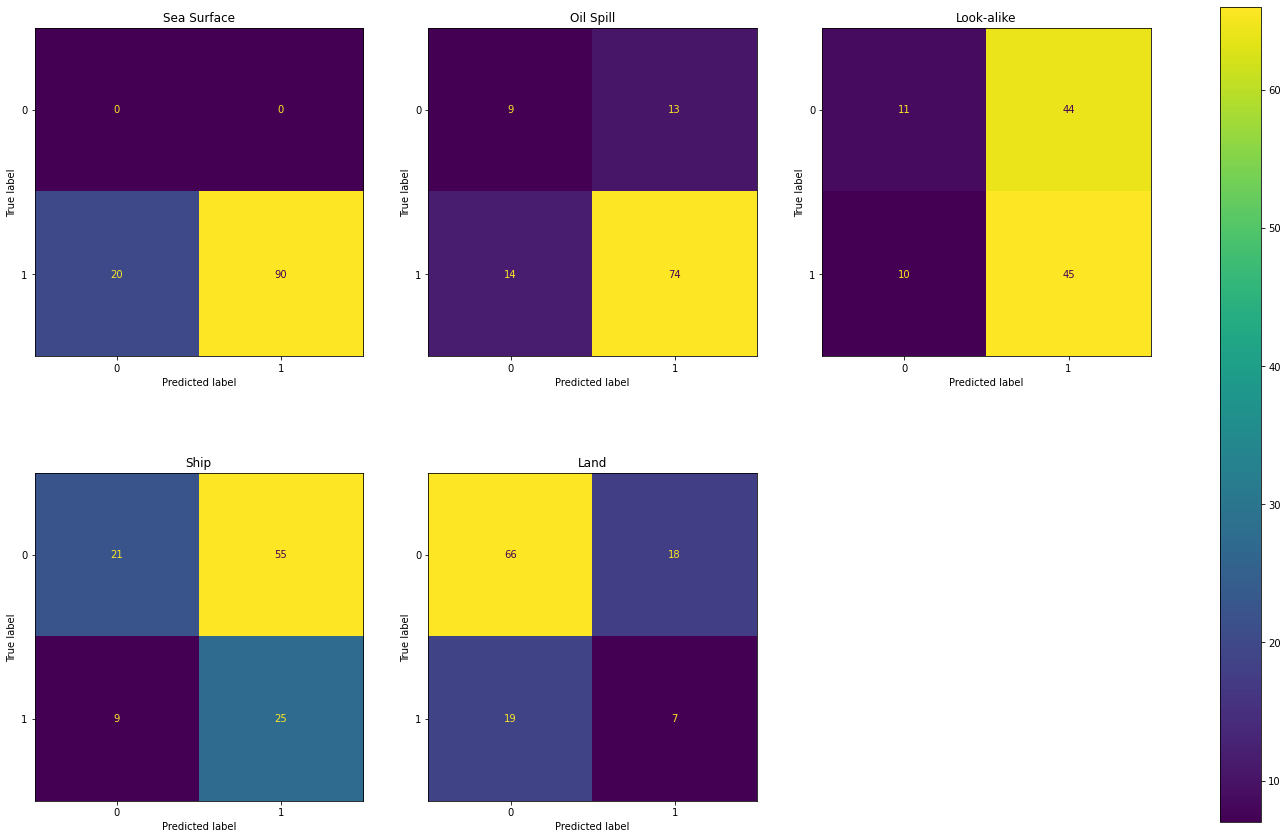

In [ ]:
printConfusionMatrices(res_noise)

Comparing the confusion matrices of the model predictions on images without and with noise, it is possible to notice that the values of True Positive and True Negative do not vary much, indeed they are sometimes greater for images affected by noise.

This indeed confirms the fact that the model is robust to noise.

# Transfer Learning

In this section I use the Transfer Learning technique to obtain a more precise model.

Since the set of images provided is relatively small to obtain a good model I use the Transfer Learning technique, a machine learning method where a model developed for a task is reused as the starting point for a model on a second task. 

I use a model trained on the ImageNet dataset, provided by tensorflow hub. 

ImageNet is an image dataset organized according to the WordNet hierarchy. Each meaningful concept in WordNet, possibly described by multiple words or word phrases, is called a "synonym set" or "synset". There are more than 100,000 synsets in WordNet; the majority of them are nouns. In ImageNet provide on average 1000 images to illustrate each synset. Images of each concept are quality-controlled and human-annotated. 

In [ ]:
#link to the model
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224, 224, 3)) #the dimension of the images on which the model was trained

I freeze the variables in the feature extractor layer, so that the training only modifies the new classification layers.

In [ ]:
feature_extractor_layer.trainable = False

Now, I wrap the feature extractor layer in a tf.keras.Sequential model and add new layers on top.

In [ ]:
model_t = Sequential([
    feature_extractor_layer,
    Dense(1024, activation='relu', name='hidden_layer'),
    Dense(5, activation='sigmoid', name='output')
])

In [ ]:
model_t.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 hidden_layer (Dense)        (None, 1024)              1311744   
                                                                 
 output (Dense)              (None, 5)                 5125      
                                                                 
Total params: 3,574,853
Trainable params: 1,316,869
Non-trainable params: 2,257,984
_________________________________________________________________


The 2.2 Millions parameters in MobileNet are frozen, but there are 1.3K trainable parameters in the dense layers.

Then I create three new generators for the images since the size of the accepted images for the new model is (224,224,3).

In [ ]:
image_size_tl = (224,224);

In [ ]:
datagen_t = ImageDataGenerator(rescale=rescale)

train_generator_t = datagen_t.flow_from_dataframe(
  dataframe=df_train_weighted,
  directory=dataset_path+'/train/images/',
  weight_col="Weights",
  x_col="Filenames",
  y_col=cols,
  batch_size=batch_size_train,
  seed=random_seed,
  shuffle=True,
  class_mode="raw",
  target_size=image_size_tl)

valid_generator_t = test_datagen.flow_from_dataframe(
  dataframe=df_test,
  directory=dataset_path+'/test/images/',
  x_col="Filenames",
  y_col=cols,
  batch_size=batch_size_train,
  seed=random_seed,
  shuffle=True,
  class_mode="raw",
  target_size=image_size_tl)

test_generator_t = test_datagen.flow_from_dataframe(
  dataframe=df_test,
  directory=dataset_path+'/test/images/',
  x_col="Filenames",
  batch_size=batch_size_test,
  seed=random_seed,
  shuffle=False,
  class_mode=None,
  target_size=image_size_tl)

Then the way to proceed is the same as before. First of all, I train the last layers of the model on the images. 

In [ ]:
model_t.compile(optimizer='adam', loss='binary_crossentropy', metrics=TRAIN_METRICS)

# Start the stopwatch / counter
t1_start = perf_counter()

STEP_SIZE_TRAIN=train_generator_t.n//train_generator_t.batch_size
STEP_SIZE_VALID=valid_generator_t.n//valid_generator_t.batch_size
STEP_SIZE_TEST=test_generator_t.n//test_generator_t.batch_size

model_t.fit(train_generator_t, epochs=number_of_ephocs, validation_data=valid_generator_t, steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID)

# Stop the stopwatch / counter
t1_stop = perf_counter()

In [ ]:
print("Elapsed time in seconds:",t1_stop-t1_start)

Elapsed time in seconds: 725.319429958


The training time is much less than the training time of the previous model.

Now I test the model on the test set of images.

In [ ]:
#get predictions
res_t, rep_t = getResults(test_generator_t, model_t, STEP_SIZE_TEST, False)

The variable *res_t* contains the dataframe with the results, while the variable *rep_t* contains the classification report,

In [ ]:
print(rep_t)

              precision    recall  f1-score   support

 Sea Surface       1.00      1.00      1.00       110
   Oil Spill       0.94      0.93      0.94        88
  Look-alike       0.71      0.65      0.68        55
        Ship       0.39      0.56      0.46        34
        Land       0.93      1.00      0.96        26

   micro avg       0.84      0.87      0.86       313
   macro avg       0.79      0.83      0.81       313
weighted avg       0.86      0.87      0.86       313
 samples avg       0.86      0.89      0.86       313



In this model the values of the metrics are much higher than before. The only class that does not have satisfactory Precision and Recall values is the '*Ship*' class, but it is not too relevant given the goal of the project. 

The results obtained with the transfer learning technique are very satisfying.

And finally I print the confusion matrix for each class.

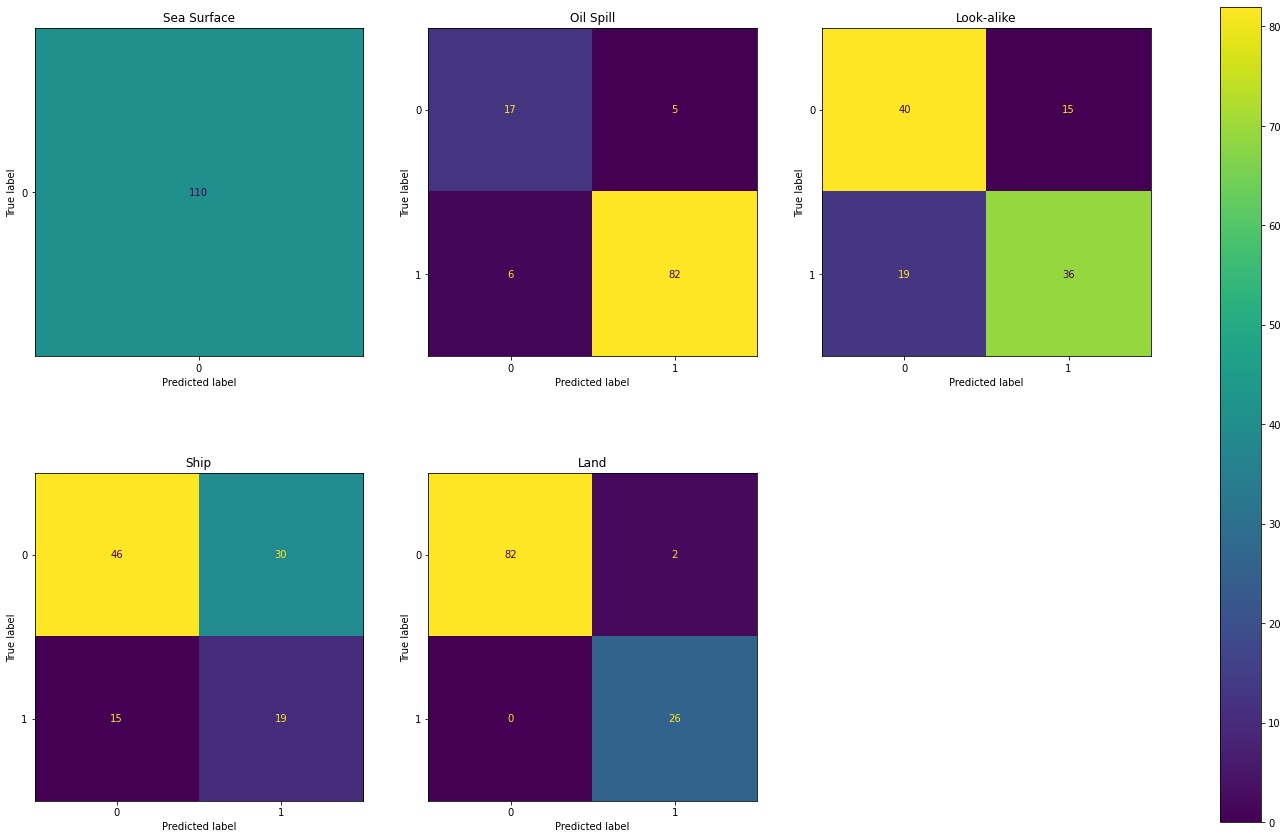

In [ ]:
printConfusionMatrices(res_t)

In these matrices it can be seen how the number of incorrectly classified elements has drastically decreased, obtaining a very large gap between correct and incorrect predictions and therefore obtaining excellent results.

## Test with noise

In this section I apply the same process as before to test the model obtained with transfer learning on images affected by noise. 

First of all I get prediction on noisy images, changing the variability of introducted noise. The range of noise variability that I test is the same as before so it goes from 40 to 130, increasing by 10 each time.

In [ ]:
res_dict_t = []
for i in range_variability:
  test_generator_noise_t = createNoiseGenerator(i, image_size_tl);
  step = test_generator_noise_t.n//test_generator_noise_t.batch_size
  res_noise_t, rep_noise_t = getResults(test_generator_noise_t, model_t, step, True);
  res_dict_t.append(rep_noise_t);

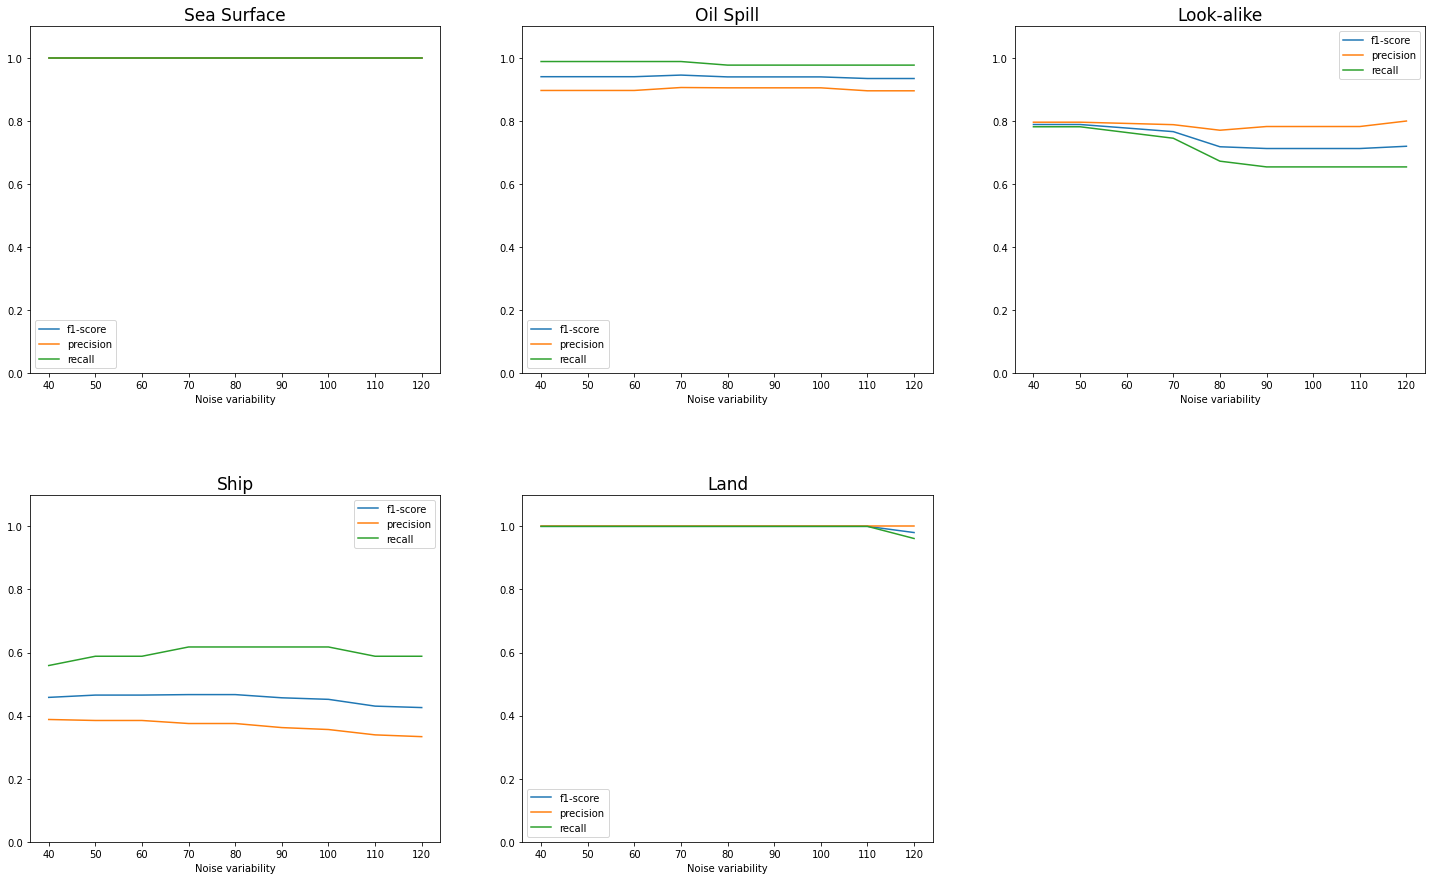

In [ ]:
printNoiseResults(res_dict_t, cols, metrics_eval, range_variability);

Accuracy and Recall values generally remain fairly stable. For some classes like '*Ship*' and '*Look-alike*' they tend to vary more by decreasing and increasing, while for the '*Land*' class there is a slight decrease in Recall and Precision when the variability is very high.

Therefore, it can seen that the model is robust to noise since the values of the metricts remain stable.

Then I print the Confusion Matrices of the results with noise variability equal to 130 to compare them with the matrices obtained on images without noise.

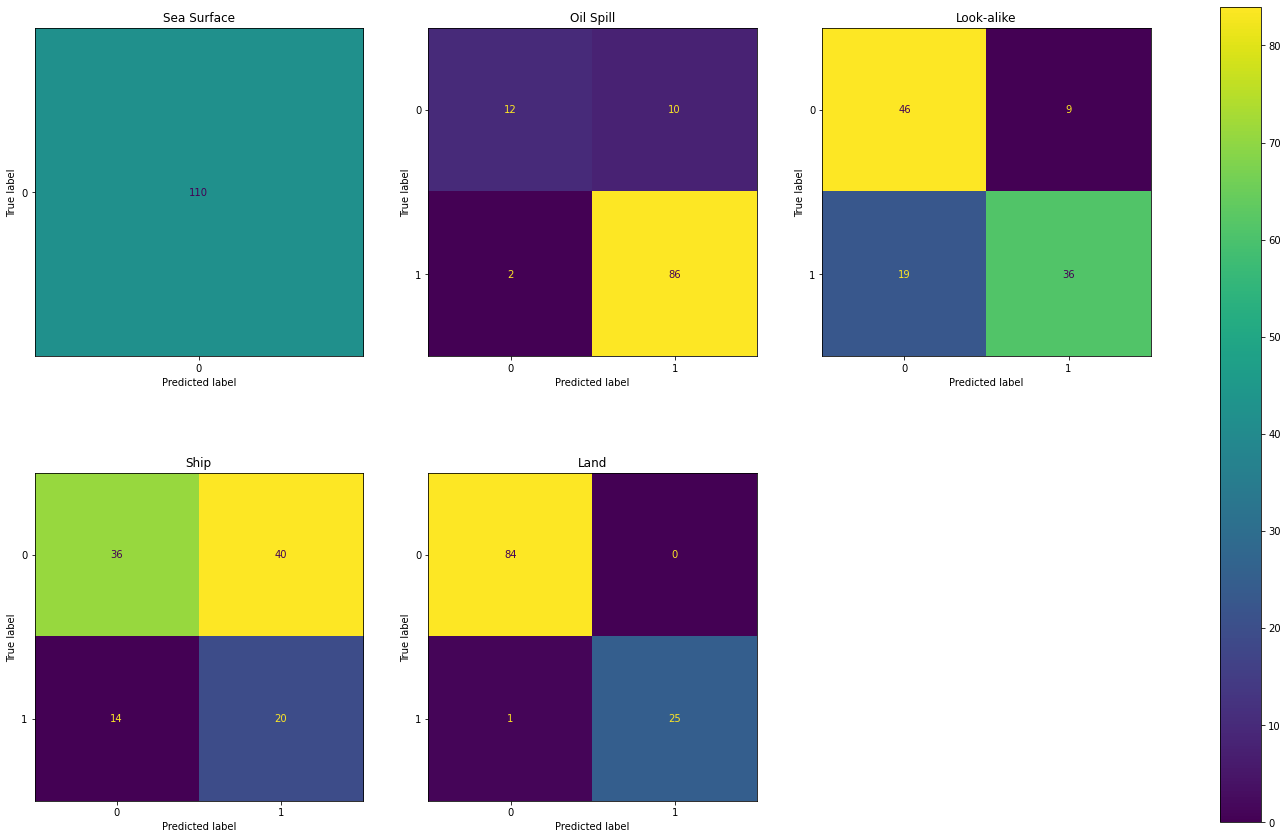

In [ ]:
printConfusionMatrices(res_noise_t)

In this case, if the confusion matrices of the model predictions on the original images are compared with those of the predictions on images with a high noise variability, the latter have the values of True Positive and True Negative lower, but not by much.

This confirms that this model is also very robust to noise.